In [1]:
import numpy as np
from matplotlib import pyplot as plt

#configure plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['figure.figsize'] =  (8,5)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(0)
import sys
sys.path.append('/Users/danmarthaler/GPclust')

#Mixture of Gaussians with GPclust

###James Hensman, November 2014
###Daniel Marthaler September 2016

This is a very simple demo to show how to use GPclust to build a mixture of Gaussians. We'll grab some toy data, fit the model and do some very simple analyis of the posterior. We'll also have a look at the truncated Dirichlet process approximation, and how to run a merge-split method to find the optimal number of clusters. Finally we'll examine the effect of changing the priors over the cluster components. 

In [2]:
X = np.load('twoD_clustering_example.npz')['X']
print(X.shape)

(506, 2)


We have a two-dimensional dataset, with 506 data.

Building the model is as simple as importing the GPclust library and calling the class constructor with our data. The argument num_clusters specifies how many clusters to use.

In [3]:
import GPclust
m = GPclust.MOG(X, num_clusters=10)

/Users/james/work/GPflow/GPflow/tf_hacks.py:28: VisibleDeprecationWarning: tf_hacks is deprecated: use tf_wraps instead
  warnings.warn('tf_hacks is deprecated: use tf_wraps instead', np.VisibleDeprecationWarning)


For two-dimensional data, there's a handy built-in plot function:

In [4]:
def plot(model,X):
    from matplotlib import pyplot as plt
    from scipy import stats

    xmin, ymin = X.min(0)
    xmax, ymax = X.max(0)
    xmin, xmax = xmin-0.1*(xmax-xmin), xmax+0.1*(xmax-xmin)
    ymin, ymax = ymin-0.1*(ymax-ymin), ymax+0.1*(ymax-ymin)
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    Xgrid = np.vstack((xx.flatten(), yy.flatten())).T

    plt.figure()
    zz = m.predict(Xgrid).reshape(100, 100)
    zz_data = m.predict(X)

    plt.contour(xx, yy, zz, [stats.scoreatpercentile(zz_data, 5)], colors='k', linewidths=3)
    plt.scatter(X[:,0], X[:,1], 30, np.argmax(m.get_phi(), 1), linewidth=0, cmap=plt.cm.gist_rainbow)

    zz_components = m.predict_components(Xgrid)
    phi_hat = m.get_phihat()
    pie = phi_hat+m.alpha
    pie /= pie.sum()
    zz_components *= pie[np.newaxis,:]
    [plt.contour(xx, yy, zz.reshape(100, 100), [stats.scoreatpercentile(zz_data, 5.)], colors='k', linewidths=1) for zz in zz_components.T]
    plt.show()

/Users/james/work/GPflow/GPflow/tf_hacks.py:28: VisibleDeprecationWarning: tf_hacks is deprecated: use tf_wraps instead
  warnings.warn('tf_hacks is deprecated: use tf_wraps instead', np.VisibleDeprecationWarning)


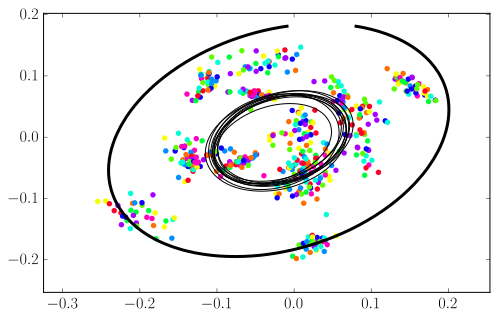

In [5]:
plot(m,X)

Here, the data are colored according to the (most probably) assigned cluster, and the heavy line(s) show the contours of the models probability density. Thin lines show the countours of the probablity density of each component.

We can see that the model has not been fitted yet! The variational approximation to the posterior is initialized randomly, i.e. all data are randomly assigned across the clusters. To fit the approximation, call the optimize routine, and plot again. 

In [6]:
m.optimize()

iteration 1 bound=840.246014825 grad=308.777145575, beta=0
iteration 2 bound=840.904453584 grad=0.561304642295, beta=0.000145126967797
iteration 3 bound=844.313288069 grad=1.08970471668, beta=1.72739699282
iteration 4 bound=862.667192938 grad=4.4287441359, beta=2.10339951231
iteration 5 bound=905.364291219 grad=20.0075932917, beta=1.69036898367
iteration 6 bound=942.805723327 grad=32.1455467813, beta=0.872266315458
iteration 7 bound=957.192541464 grad=16.2657449467, beta=2.01942104877
iteration 8 bound=979.483253179 grad=26.1791267443, beta=0.0
iteration 9 bound=997.650732933 grad=20.1588678969, beta=0.0
iteration 10 bound=1025.24614454 grad=24.7127078571, beta=0.776332812145
iteration 11 bound=1055.84290373 grad=22.6919812444, beta=0.804864402663
iteration 12 bound=1090.62196011 grad=29.3128570809, beta=1.14300857503
iteration 13 bound=1119.86720392 grad=31.4465758757, beta=0.790716925372
iteration 14 bound=1157.89806837 grad=29.6376075378, beta=2.67596965734
iteration 16 bound=1183.9

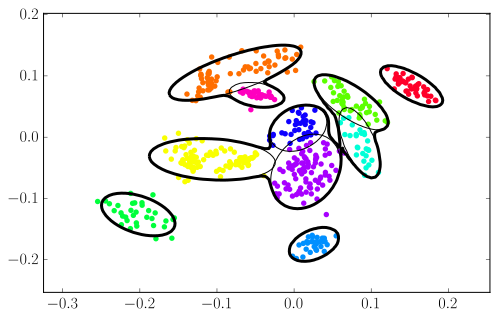

In [7]:
plot(m,X)

#Dirichlet process priors and the merge-split method
Instead of using a fixed number of clusters, we can place a Dirichlet process prior over the component weights: effectively a prior of an infintie number of clusters. The variational approximation is _truncated_ se we still only model a finite number of clusters, but now we can optimize for the number of components.

To help explore the search space, GPclust has a `try_split` function. This re-initialized the posterior with a cluster 'split' into two. Attempted splits are only accepted if the bound onthe marginal likelihood increases.  A wrapper around the `try_split()`, method, `systematic_splits()` repeatedly attempts splits. 

Let's build a MOG with a DP prior, truncated at four components:

iteration 1 bound=1508.54438995 grad=2283.56402294, beta=0
iteration 2 bound=1707.76882183 grad=306.223328038, beta=0.0
iteration 3 bound=1847.06343538 grad=218.79281684, beta=0.403596981987
iteration 4 bound=1914.71166336 grad=126.104992912, beta=0.256810901251
iteration 5 bound=1945.45527316 grad=55.5493213586, beta=0.206758094706
iteration 6 bound=1959.92090634 grad=27.267750647, beta=0.234112807238
iteration 7 bound=1968.3054064 grad=14.5406621885, beta=0.251008391687
iteration 8 bound=1971.57731402 grad=7.24989990258, beta=0.233970837583
iteration 9 bound=1972.52789353 grad=2.55805436541, beta=0.165945556951
iteration 10 bound=1972.57961487 grad=0.304722807857, beta=0.0570623789556
iteration 11 bound=1972.57973046 grad=0.00139264222074, beta=0.00225162564128
iteration 12 bound=1972.57973046 grad=1.56183258734e-08, beta=5.6042428717e-06
vb converged (ftol)


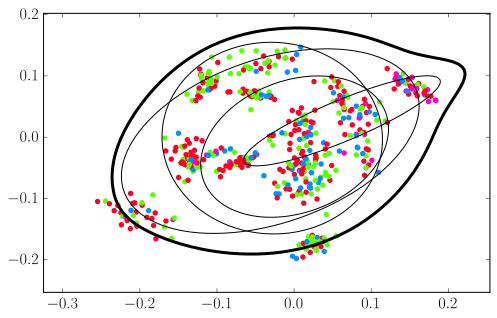

In [10]:
m = GPclust.MOG(X, num_clusters=4, prior_Z='DP', alpha=10.)
m.optimize()
plot(m,X)

With only four components, the fit is quite poor. To attempt to split the $i^\textrm{th}$ component, call `try_split(i)`. The method returns `True` if the split was sucessful, and displays the current status after each split attempt. 

In [9]:
m.try_split(1)


attempting to split cluster  1


InvalidArgumentError: Input to reshape is a tensor with 20 values, but the requested shape has 16
	 [[Node: Reshape_21 = Reshape[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/cpu:0"](MatMul_7, pack_33)]]
Caused by op u'Reshape_21', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8483a76f8032>", line 2, in <module>
    m.optimize()
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_vb.py", line 73, in optimize
    bound_old, grad_old, natgrad_old = self.vb_bound_grad_natgrad()
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 493, in runnable
    storage['tf_result'] = tf_method(instance, *storage['tf_args'])
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 97, in vb_bound_grad_natgrad
    bound = self.build_likelihood()
  File "/Users/danmarthaler/GPclust/GPclust/MOG.py", line 63, in build_likelihood
    Ck = tf.reshape(tf.matmul(self.reshapeXXT,phi),tf.pack([self.D,self.D,self.num_clusters]))
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1750, in reshape
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


In [10]:
plot(m,X)

InvalidArgumentError: Input to reshape is a tensor with 20 values, but the requested shape has 16
	 [[Node: Reshape_30 = Reshape[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/cpu:0"](MatMul_9, pack_44)]]
Caused by op u'Reshape_30', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2815, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8483a76f8032>", line 3, in <module>
    plot(m,X)
  File "<ipython-input-4-a22f4119cae3>", line 13, in plot
    zz = m.predict(Xgrid).reshape(100, 100)
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 493, in runnable
    storage['tf_result'] = tf_method(instance, *storage['tf_args'])
  File "/Users/danmarthaler/GPclust/GPclust/MOG.py", line 125, in predict
    Z = self.predict_components_tf(Xnew)
  File "/Users/danmarthaler/GPclust/GPclust/MOG.py", line 89, in predict_components_tf
    Ck = tf.reshape(tf.matmul(self.reshapeXXT,phi),tf.pack([self.D,self.D,self.num_clusters]))
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1750, in reshape
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


We can see that in attempting to split the first cluster, the bound on the marginal likelihood has increased and the move was accepted. To save having to repeatedly call the `try_split` method, there's a helpful `systematic_splits()` function, which iterates through each cluster and attempts to split it until the marginal-likelihood bound fails to increase. Here we'll turn the output off, as it can get a bit long.

In [11]:
m.systematic_splits(verbose=False)

InvalidArgumentError: Input to reshape is a tensor with 20 values, but the requested shape has 16
	 [[Node: Reshape_42 = Reshape[T=DT_DOUBLE, _device="/job:localhost/replica:0/task:0/cpu:0"](MatMul_13, pack_64)]]
Caused by op u'Reshape_42', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2815, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-60a73b3ac9ed>", line 1, in <module>
    m.try_split(1)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 152, in try_split
    bound_old = self.bound()
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_mixture.py", line 89, in bound
    return self.compute_log_likelihood()
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 493, in runnable
    storage['tf_result'] = tf_method(instance, *storage['tf_args'])
  File "/Users/danmarthaler/GPflow/GPflow/model.py", line 168, in compute_log_likelihood
    return self.build_likelihood()
  File "/Users/danmarthaler/GPclust/GPclust/MOG.py", line 63, in build_likelihood
    Ck = tf.reshape(tf.matmul(self.reshapeXXT,phi),tf.pack([self.D,self.D,self.num_clusters]))
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1750, in reshape
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


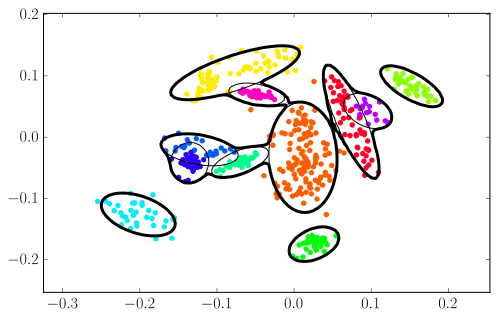

In [11]:
plot(m,X)

##Getting at the parameters of the posterior. 
There are perhaps three main tasks that we'd like to do with the fitted model:
* See which data are assigned to the same cluster
* Examine the means (and variances) of the cluster components
* Predict the probability density at a new point

The posterior over data assignments is stored in a matix called `phi`. This matrix is NxK, and each element $\phi_{nk}$ represents the probability that the $n^\textrm{th}$ datum is assigned to the $k^\textrm{th}$ component. Here we'll visualize the posterior assignment probabilities in a heatmap-style plot.

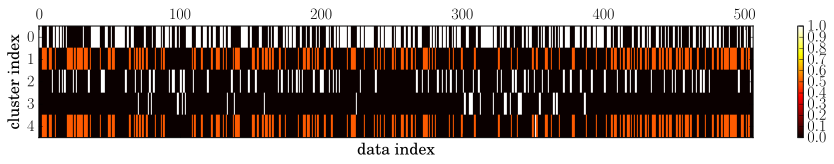

In [6]:
phi = m.get_phi()
_=plt.matshow(phi.T, cmap=plt.cm.hot, vmin=0, vmax=1, aspect='auto')
plt.xlabel('data index')
plt.ylabel('cluster index')
_=plt.colorbar()

The variational posterior for each of the components in the MOG model is a Gaussian-Wishart distribution. These are stored in the model as so:

In [17]:
print 'first component mean:', m.mun[:,0]
print 'first component covariance:\n', m.Sns[:,:,0]


first component mean:

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11ae96ed0>> ignored


InvalidArgumentError: You must feed a value for placeholder tensor 'unnamed_8' with dtype double
	 [[Node: unnamed_8 = Placeholder[dtype=DT_DOUBLE, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'unnamed_8', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-8483a76f8032>", line 1, in <module>
    m = GPclust.MOG(X, num_clusters=4, prior_Z='DP', alpha=10.)
  File "/Users/danmarthaler/GPclust/GPclust/MOG.py", line 32, in __init__
    self.X = GPflow.param.DataHolder(X, on_shape_change='pass')
  File "/Users/danmarthaler/GPflow/GPflow/param.py", line 371, in __init__
    name=self.name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1274, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1522, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


Finally, to obtain the predictive density of the model at any point, we can use `m.predict`. To get the density under each of the components, we can use `m.predict_components'.

In [14]:
test_point = np.array([[0.1, 0.0]])
density = m.predict(test_point)
print 'model density:',density

cw_density = m.predict_components(test_point)
print 'density under each component:', cw_density.round(3)


model density: [ 6.13456833]
density under each component: [[  5.58920000e+01   2.00000000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.05150000e+01   0.00000000e+00]]


##Adjusting the prior parameters
The MOG model has priors over the component means and covariances (Gaussian Wishart) and a Dirichlet (or Dirichlet-process) prior over the mixing proportions. We'll use the 2D dataset to illustrate how to change these prior parameters and the effect of them. 

First, let's place a strong prior over the cluster covariances that forces them to be small, and a large concentration parameter, which makes the Dirichlet process prefer a large number of clusters. 



In [8]:
print m.log_likelihood()

AttributeError: 'MOG' object has no attribute 'log_likelihood'

bound on the marginal likelihood: 3254.36378158


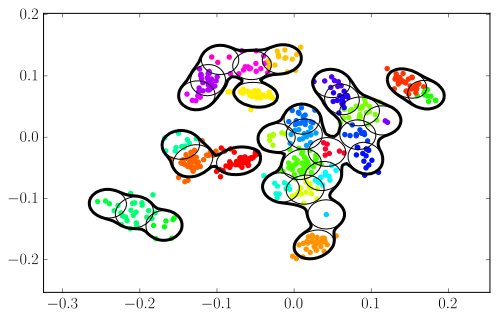

In [15]:
m = GPclust.MOG(X, num_clust=10, prior_S=np.eye(2)*5e-3, prior_v=30., prior_Z='DP', alpha=100)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
m.plot()
print 'bound on the marginal likelihood:', m.log_likelihood()

We see that the model finds a very large number of small clusters! Now let's see what happens if we relax the concentration parameter, and reduce the strength of the Wishart prior:

bound on the marginal likelihood: 1548.07214763


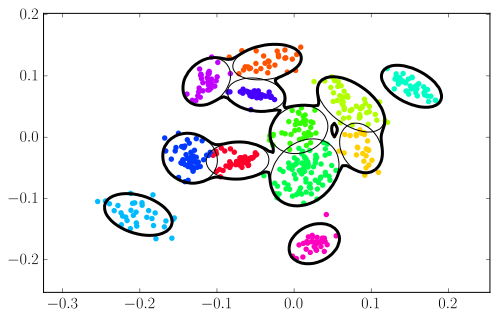

In [16]:
m = GPclust.MOG(X, K=10, prior_S=np.eye(2)*5e-3, prior_v=10., prior_Z='DP', alpha=0.1)
m.optimize(verbose=False)
m.systematic_splits(verbose=False)
m.systematic_splits(verbose=False)
m.plot()
print 'bound on the marginal likelihood:', m.log_likelihood()

The MOG also takes a prior mean parameter (which defalts to the mean of the data) and a prior concentration parameter as part of the Wishart distribution. We leave experimenting with these to the reader. 